## 1. 2D Data

In [1]:
import numpy as np
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, 
                    noise=0.03)


In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
X[:5]

array([[ 0.59313737,  0.77597531],
       [ 0.47454465,  0.65963365],
       [-0.80754573,  0.22330129],
       [-0.70441302,  0.43968629],
       [ 0.44441391,  0.85146109]])

In [4]:
print(X[:5], y[:5])

[[ 0.59313737  0.77597531]
 [ 0.47454465  0.65963365]
 [-0.80754573  0.22330129]
 [-0.70441302  0.43968629]
 [ 0.44441391  0.85146109]] [0 1 1 1 0]


In [5]:
set(y)

{0, 1}

Looks like binary classification to me

In [6]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.593137,0.775975,0
1,0.474545,0.659634,1
2,-0.807546,0.223301,1
3,-0.704413,0.439686,1
4,0.444414,0.851461,0


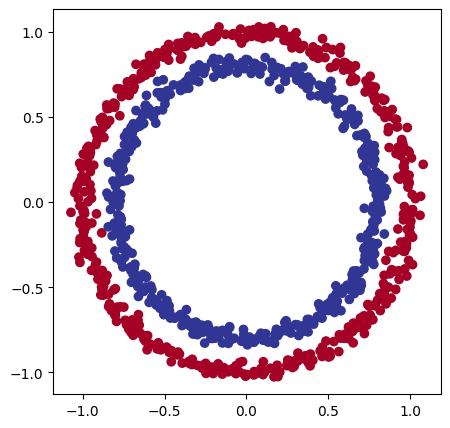

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
import torch
from torch import nn

X_tensor = torch.from_numpy(X).type(torch.float32).to('cuda')
y_tensor = torch.from_numpy(y).type(torch.float32).to('cuda')

In [10]:
X_tensor.shape

torch.Size([1000, 2])

In [11]:
y_tensor.shape

torch.Size([1000])

In [12]:
y_tensor = y_tensor.unsqueeze(dim=1)

In [13]:
y_tensor.shape

torch.Size([1000, 1])

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, 
                                                    y_tensor, 
                                                    test_size=0.2)


In [15]:
X_train.size(), X_test.size(), y_train.size(), y_test.size()

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800, 1]),
 torch.Size([200, 1]))

## 2. Building a model

In [16]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
        
    def forward(self, x):
        x = self.layer_1(x)
        return self.layer_2(x)
    
model = CircleModel().to('cuda')
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3790, -0.6124],
                      [-0.0072, -0.4656],
                      [ 0.6377, -0.6398],
                      [ 0.2197, -0.0282],
                      [-0.4218, -0.0451],
                      [ 0.3117,  0.2685],
                      [-0.4322, -0.6481],
                      [ 0.0096, -0.6790]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.1023, -0.6895, -0.6348,  0.4604,  0.6036,  0.1543, -0.4262,  0.3312],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2303, -0.1711,  0.0763,  0.1524,  0.1488, -0.1917, -0.2898,  0.2391]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([-0.2439], device='cuda:0'))])

In [18]:
model_sequential = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to('cuda')

model_sequential

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
model.eval()
with torch.inference_mode():
    untrained_preds = model(X_test.type(torch.float32))
untrained_preds[:10]

tensor([[0.2269],
        [0.2229],
        [0.2623],
        [0.0916],
        [0.1883],
        [0.2735],
        [0.1922],
        [0.0333],
        [0.1256],
        [0.0625]], device='cuda:0')

In [20]:
untrained_preds.max()

tensor(0.3334, device='cuda:0')

### 2.1 Setup loss function and optimizer

In [21]:
# Loss function:
# Regression model: MAE, MSE
# Classification: binary cross entropy, categorical cross entropy

![table](./source/classification_hyperparameters.png)

![table2](./source/loss_function_optimizer.png)

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
def accuracy_fn(y_true, y_pred):
    correct = torch.sum(y_true == y_pred)
    return correct / len(y_pred) * 100

In [24]:
model.eval()
with torch.inference_mode():
    y_pred_first = model(X_test)[:5]
y_pred_first

tensor([[0.2269],
        [0.2229],
        [0.2623],
        [0.0916],
        [0.1883]], device='cuda:0')

In [25]:
torch.round(y_pred_first)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [26]:
torch.sigmoid(y_pred_first)

tensor([[0.5565],
        [0.5555],
        [0.5652],
        [0.5229],
        [0.5469]], device='cuda:0')

In [27]:
torch.round(torch.sigmoid(y_pred_first))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [28]:
torch.round(torch.sigmoid(y_pred_first)) == y_test[:5]

tensor([[ True],
        [False],
        [False],
        [ True],
        [False]], device='cuda:0')

In [29]:
accuracy = accuracy_fn(y_test[:5], torch.round(torch.sigmoid(y_pred_first)))
accuracy

tensor(40., device='cuda:0')

In [30]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    y_logits_step = model(X_train)
    y_pred_step = torch.round(y_logits_step)
    loss = loss_fn(y_logits_step,# BCEWithLogits expects logits (no activation)
                   y_train) 
    # Example with BCELoss
    # loss_no_logits = nn.BCELoss()
    # loss_no_logits(torch.sigmoid(y_logits_step), y_train)
    # BCELoss expects values from 0 to 1, BCEWithLogits activates it itself because it already has a sigmoid layer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
        print(f"Epoch: {epoch}, Test Loss: {test_loss}, Test Accuracy: {test_acc}%")
        
    

Epoch: 0, Test Loss: 0.6932973861694336, Test Accuracy: 62.5%
Epoch: 10, Test Loss: 0.6981952786445618, Test Accuracy: 47.0%
Epoch: 20, Test Loss: 0.6949036717414856, Test Accuracy: 45.999996185302734%
Epoch: 30, Test Loss: 0.6961800456047058, Test Accuracy: 41.5%
Epoch: 40, Test Loss: 0.6952041983604431, Test Accuracy: 43.5%
Epoch: 50, Test Loss: 0.6959354877471924, Test Accuracy: 41.5%
Epoch: 60, Test Loss: 0.6954569816589355, Test Accuracy: 44.0%
Epoch: 70, Test Loss: 0.6956203579902649, Test Accuracy: 41.0%
Epoch: 80, Test Loss: 0.6956533789634705, Test Accuracy: 41.5%
Epoch: 90, Test Loss: 0.6955541968345642, Test Accuracy: 42.0%
Epoch: 100, Test Loss: 0.6956324577331543, Test Accuracy: 41.0%
Epoch: 110, Test Loss: 0.695601761341095, Test Accuracy: 41.0%
Epoch: 120, Test Loss: 0.6955984830856323, Test Accuracy: 41.0%
Epoch: 130, Test Loss: 0.6956100463867188, Test Accuracy: 41.0%
Epoch: 140, Test Loss: 0.6956048607826233, Test Accuracy: 41.0%
Epoch: 150, Test Loss: 0.6956042051315

## 3 Making predictions

### This model is shit. Let's try some predictions with it

In [31]:
def plot_decision_boundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor, last_activation=lambda x: x):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    # mashgrid creates all possible coordinates from a combination of linspaces

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    # ravel flattens the tensor into 1 dimension
    # column stack stacks the arrays in 2 different columns
    # (creates a matrix of shape (len(xx) x 2), len(xx) == len(yy)

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        # y_pred = torch.round(y_logits)
        y_pred = torch.round(last_activation(y_logits))
        # y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


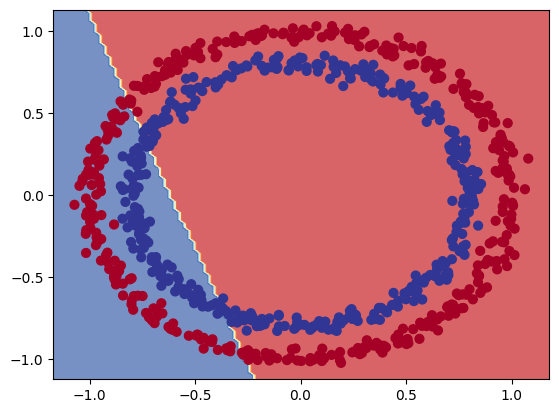

In [32]:
plot_decision_boundary(model, X_train, y_train, last_activation=torch.sigmoid)

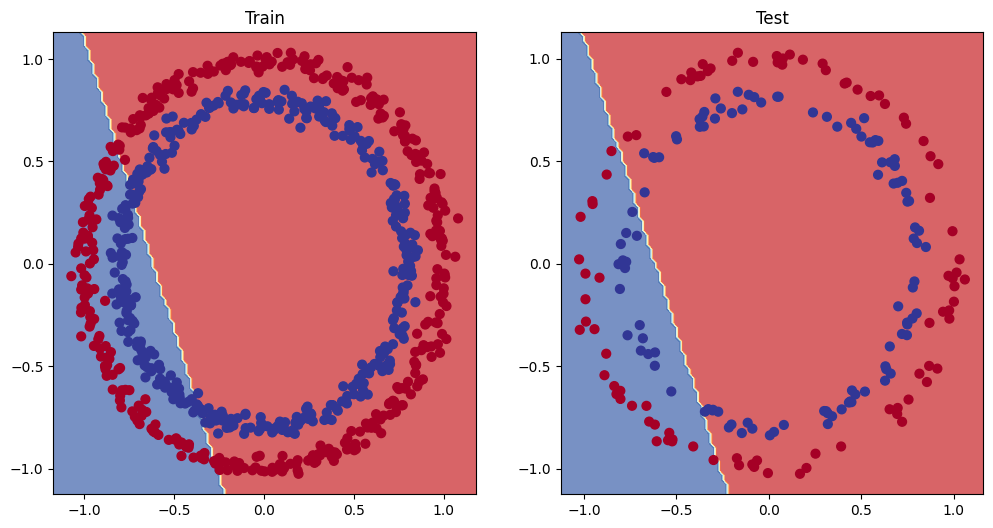

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train, last_activation=torch.sigmoid)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test, last_activation=torch.sigmoid)

### Maybe we just can't separate circular data with linear layers

## 4 Improving the model

In [34]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [35]:
model_2 = CircleModelV2().to('cuda')
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)

In [36]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)

In [37]:
epochs = 1000
for epoch in range(epochs):
    model_2.train()
    y_pred_step = model_2(X_train)
    loss = loss_fn(y_pred_step, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model_2.eval()
        with torch.inference_mode():
            y_pred_logits = model_2(X_test)
            y_pred_test = torch.round(torch.sigmoid(y_pred_logits))
            loss = loss_fn(y_pred_test, y_test)
            accuracy = accuracy_fn(y_test, y_pred_test)
        
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}%")

Epoch: 0, Loss: 0.7430, Accuracy: 44.0000%
Epoch: 10, Loss: 0.7411, Accuracy: 44.5000%
Epoch: 20, Loss: 0.7439, Accuracy: 42.5000%
Epoch: 30, Loss: 0.7451, Accuracy: 42.5000%
Epoch: 40, Loss: 0.7537, Accuracy: 41.5000%
Epoch: 50, Loss: 0.7513, Accuracy: 41.5000%
Epoch: 60, Loss: 0.7477, Accuracy: 41.5000%
Epoch: 70, Loss: 0.7458, Accuracy: 42.0000%
Epoch: 80, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 90, Loss: 0.7477, Accuracy: 41.5000%
Epoch: 100, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 110, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 120, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 130, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 140, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 150, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 160, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 170, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 180, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 190, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 200, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 210, Loss: 0.7508, Accuracy: 41.0000%
Epoch: 220, Loss: 0.7

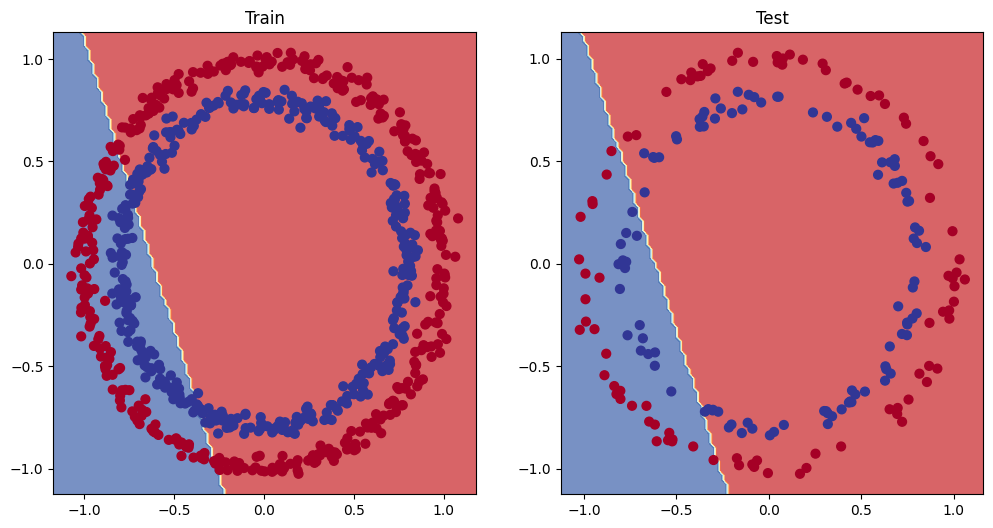

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train, last_activation=torch.sigmoid)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test, last_activation=torch.sigmoid)

### This still being shit. We have to modify our model so it can process none linear data

In [39]:
class CircleModelNonLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.sigmoid(x)
        return x

In [40]:
model_3 = CircleModelNonLinear().to('cuda')
model_3

CircleModelNonLinear(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [41]:
model_3.eval()
with torch.inference_mode():
    first_pred = model_3(X_train)
first_pred[:5]

tensor([[0.4210],
        [0.4145],
        [0.4461],
        [0.4102],
        [0.4253]], device='cuda:0')

In [42]:
optimizer = torch.optim.Adam(model_3.parameters(), 
                             lr=0.01)
loss_fn = nn.BCELoss()

In [43]:
epochs = 100

for epoch in range(epochs):
    model_3.train()
    y_pred_step = model_3(X_train)
    loss = loss_fn(y_pred_step, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model_3.eval()
        with torch.inference_mode():
            y_pred_test = model_3(X_test)
            loss = loss_fn(y_pred_test, y_test)
            accuracy = accuracy_fn(y_test, torch.round(y_pred_test))
            
            print(f"Epoch: {epoch}, Loss: {loss.item()}, accuracy: {accuracy}%")

Epoch: 0, Loss: 0.70867520570755, accuracy: 47.0%
Epoch: 10, Loss: 0.6844482421875, accuracy: 60.499996185302734%
Epoch: 20, Loss: 0.6634348630905151, accuracy: 68.0%
Epoch: 30, Loss: 0.6128778457641602, accuracy: 82.0%
Epoch: 40, Loss: 0.5128518342971802, accuracy: 94.0%
Epoch: 50, Loss: 0.3774474561214447, accuracy: 97.5%
Epoch: 60, Loss: 0.2381240427494049, accuracy: 98.99999237060547%
Epoch: 70, Loss: 0.1359863579273224, accuracy: 99.5%
Epoch: 80, Loss: 0.07887038588523865, accuracy: 100.0%
Epoch: 90, Loss: 0.04642530158162117, accuracy: 100.0%


In [44]:
model_3.eval()
with torch.inference_mode():
    y_pred_final = torch.round(model_3(X_test))
y_pred_final[:5]

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

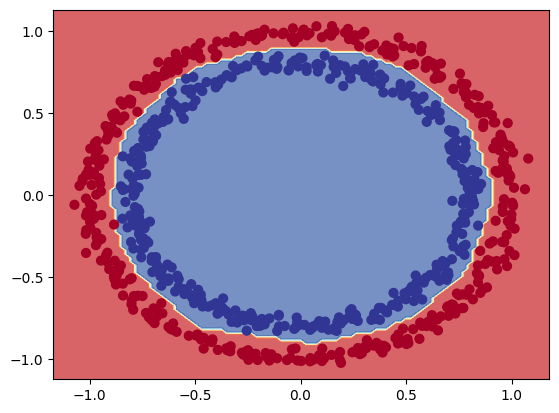

In [45]:
plot_decision_boundary(model_3, X_train, y_train)

In [46]:
torch.round(model_3(torch.tensor([[0.9, 0.9], [0.5, 0.6]])))

tensor([[0.],
        [1.]], grad_fn=<RoundBackward0>)